In [1]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("data/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("data/credit_record.csv", encoding = 'utf-8')  

In [3]:
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg("min"))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID")

In [4]:
record['dep_value'] = None
record.loc[record['STATUS'] == '2', 'dep_value'] = 'Yes'
record.loc[record['STATUS'] == '3', 'dep_value'] = 'Yes'
record.loc[record['STATUS'] == '4', 'dep_value'] = 'Yes'
record.loc[record['STATUS'] == '5', 'dep_value'] = 'Yes'

# cpunt=record.groupby('ID').count()
# cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
# cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
# cpunt = cpunt[['dep_value']]
# new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
# new_data['target']=new_data['dep_value']
# new_data.loc[new_data['target']=='Yes','target']=1
# new_data.loc[new_data['target']=='No','target']=0

In [5]:
grouped_cnt=record.groupby('ID').count()
grouped_cnt.loc[grouped_cnt['dep_value'] > 0, 'dep_value'] = 'Yes'
grouped_cnt.loc[grouped_cnt['dep_value'] == 0, 'dep_value'] = 'No'
grouped_cnt = grouped_cnt[['dep_value']]
new_data=pd.merge(new_data,grouped_cnt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target'] = 1
new_data.loc[new_data['target']=='No','target'] = 0

/tmp/ipykernel_5640/2957871274.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Yes' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_cnt.loc[grouped_cnt['dep_value'] > 0, 'dep_value'] = 'Yes'


In [6]:
new_data = new_data.drop(columns=[
    'ID',
    'dep_value',
    'FLAG_MOBIL',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'begin_month'
    
])
new_data = new_data.dropna()

In [7]:
new_data.shape

(25134, 14)

In [8]:
new_data.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target'],
      dtype='object')

In [9]:
class_counts = new_data['target'].value_counts(normalize=True) * 100
print("Class Imbalance (in %):")
print(class_counts)

Class Imbalance (in %):
target
0    98.320999
1     1.679001
Name: proportion, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

categorical_columns = new_data.select_dtypes(include=['object']).columns
new_data[categorical_columns] = new_data[categorical_columns].astype('category')

new_data.rename(columns=lambda col: col.replace("NAME_", "CODE_") if col.startswith("NAME_") else col, inplace=True)
new_data.rename(
    columns={
        'OCCUPATION_TYPE': 'CODE_OCCUPATION_TYPE',
        'CNT_FAM_MEMBERS': 'CNT_FAMILY_MEMBERS'
        },
    inplace=True
)

categorical_columns = new_data.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    new_data[col] = le.fit_transform(new_data[col])
    label_encoders[col] = le

new_data.columns = new_data.columns.str.lower()


X = new_data.drop(columns=['target'])
y = new_data['target']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [11]:
import json

label_encoders_dict = {}
for col, le in label_encoders.items():
    label_encoders_dict[col] = {int(value): str(label) for value, label in enumerate(le.classes_)}

with open('data/label_encoders.json', 'w') as json_file:
    json.dump(label_encoders_dict, json_file, indent=4)


In [12]:
class_counts = y_resampled.value_counts(normalize=True) * 100
print("Resampled Class Imbalance (in %):")
print(class_counts)

Resampled Class Imbalance (in %):
target
0    50.0
1    50.0
Name: proportion, dtype: float64


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


model = XGBClassifier(
    learning_rate = 0.02,
    max_depth=12,
    n_estimators=250,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/home/kirill/miniconda3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:21:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9852
Precision: 0.9871
Recall: 0.9836
F1-Score: 0.9853

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4894
           1       0.99      0.98      0.99      4991

    accuracy                           0.99      9885
   macro avg       0.99      0.99      0.99      9885
weighted avg       0.99      0.99      0.99      9885



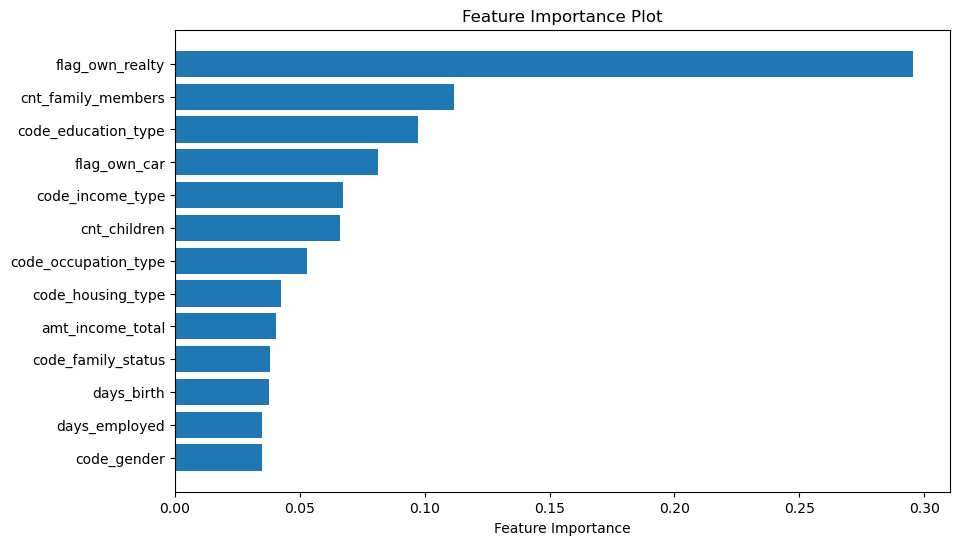

In [14]:
plt.figure(figsize=(10, 6))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

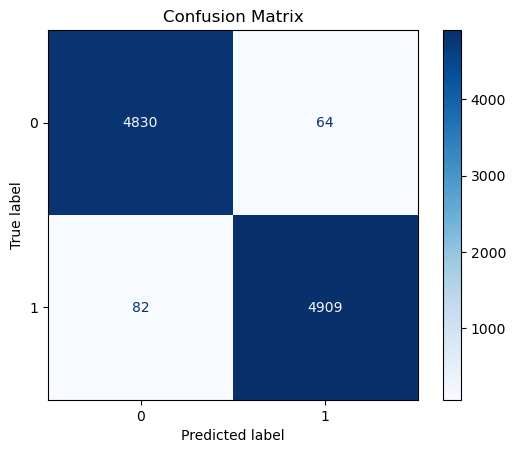

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [16]:
y_test

31542    1
25501    1
1536     0
13373    0
19409    0
        ..
32887    1
41419    1
22922    0
21167    0
26915    1
Name: target, Length: 9885, dtype: int64

In [17]:
import shap

sample = X_test.iloc[6].values.reshape(1, -1)

explainer = shap.Explainer(model)
shap_values = explainer(sample)

shap_values_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Value': sample[0],
    'SHAP Value': shap_values.values[0]
})


shap_values_df['AbsImpact'] = shap_values_df['SHAP Value'].abs()
# shap_values_df = shap_values_df.sort_values('AbsImpact', ascending=False)


print("Prediction: ", model.predict(sample))
print(shap_values_df[['Feature', 'Value', 'SHAP Value']])

/home/kirill/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prediction:  [1]
                 Feature     Value  SHAP Value
0            code_gender       0.0    0.117022
1           flag_own_car       0.0    0.319409
2        flag_own_realty       1.0   -0.433915
3           cnt_children       0.0    0.324814
4       amt_income_total  270000.0    0.224447
5       code_income_type       2.0    0.506839
6    code_education_type       2.0    1.054009
7     code_family_status       1.0    0.039281
8      code_housing_type       1.0    0.030945
9             days_birth  -17378.0    0.358190
10         days_employed    -439.0    0.134674
11  code_occupation_type       3.0    0.137106
12    cnt_family_members       2.0   -0.421155


In [18]:
shap_values = shap_values.values.flatten()

levels = []

neutral_threshold = np.percentile(np.abs(shap_values), 20)

max_pos = shap_values[shap_values > 0].max(initial=0)
max_neg = shap_values[shap_values < 0].min(initial=0)  # this is negative

for val in shap_values:
    if abs(val) < neutral_threshold:
        levels.append('0')
    elif val > 0:
        if val > 0.5 * max_pos:
            levels.append('--')
        else:
            levels.append('-')
    else:
        if val < 0.5 * max_neg:  # remember: max_neg is negative
            levels.append('++')
        else:
            levels.append('+')


In [19]:
print(levels)
print(shap_values_df[['Feature', 'Value', 'SHAP Value']])


['0', '-', '++', '-', '-', '-', '--', '0', '0', '-', '-', '-', '++']
                 Feature     Value  SHAP Value
0            code_gender       0.0    0.117022
1           flag_own_car       0.0    0.319409
2        flag_own_realty       1.0   -0.433915
3           cnt_children       0.0    0.324814
4       amt_income_total  270000.0    0.224447
5       code_income_type       2.0    0.506839
6    code_education_type       2.0    1.054009
7     code_family_status       1.0    0.039281
8      code_housing_type       1.0    0.030945
9             days_birth  -17378.0    0.358190
10         days_employed    -439.0    0.134674
11  code_occupation_type       3.0    0.137106
12    cnt_family_members       2.0   -0.421155


In [27]:
import shap

sample = X_test.loc[41419].values.reshape(1, -1)
# sample[0][0] = 0

# [[0.01586676 0.98413324]]

explainer = shap.Explainer(model)
shap_values = explainer(sample)

abs_total = np.sum(np.abs(shap_values.values[0]))
normalized_shap = shap_values / abs_total

shap_values_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Value': sample[0],
    'SHAP Value': shap_values.values[0],
    "Normalized SHAP": normalized_shap.values[0]
})


shap_values_df['AbsImpact'] = shap_values_df['SHAP Value'].abs()
# shap_values_df = shap_values_df.sort_values('AbsImpact', ascending=False)


print("Prediction: ", model.predict(sample), model.predict_proba(sample))
print(shap_values_df)

Prediction:  [1] [[0.01536775 0.98463225]]
                 Feature     Value  SHAP Value  Normalized SHAP  AbsImpact
0            code_gender       1.0   -0.196154        -0.033229   0.196154
1           flag_own_car       1.0   -0.232080        -0.039315   0.232080
2        flag_own_realty       1.0    0.381516         0.064630   0.381516
3           cnt_children       0.0    0.625830         0.106017   0.625830
4       amt_income_total  202500.0    0.876116         0.148417   0.876116
5       code_income_type       4.0   -0.102484        -0.017361   0.102484
6    code_education_type       1.0   -0.036436        -0.006172   0.036436
7     code_family_status       2.0    0.434307         0.073573   0.434307
8      code_housing_type       1.0    0.009239         0.001565   0.009239
9             days_birth  -17585.0    0.913986         0.154832   0.913986
10         days_employed   -3017.0    0.440739         0.074663   0.440739
11  code_occupation_type       4.0    1.356861         0.

In [25]:
sample

array([[-1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,  2.0250e+05,
         4.0000e+00,  1.0000e+00,  2.0000e+00,  1.0000e+00, -1.7585e+04,
        -3.0170e+03,  4.0000e+00,  2.0000e+00]])

In [ ]:
sample[0][0] = 0

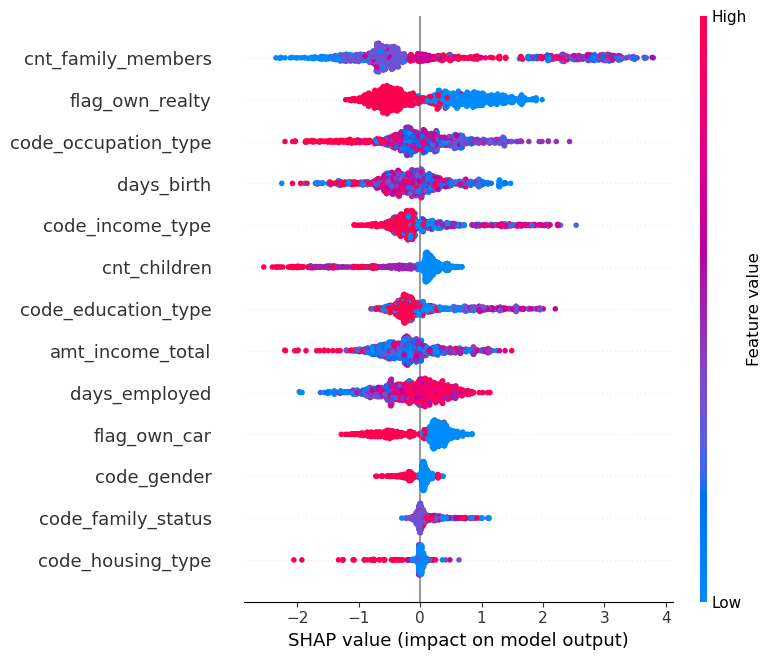

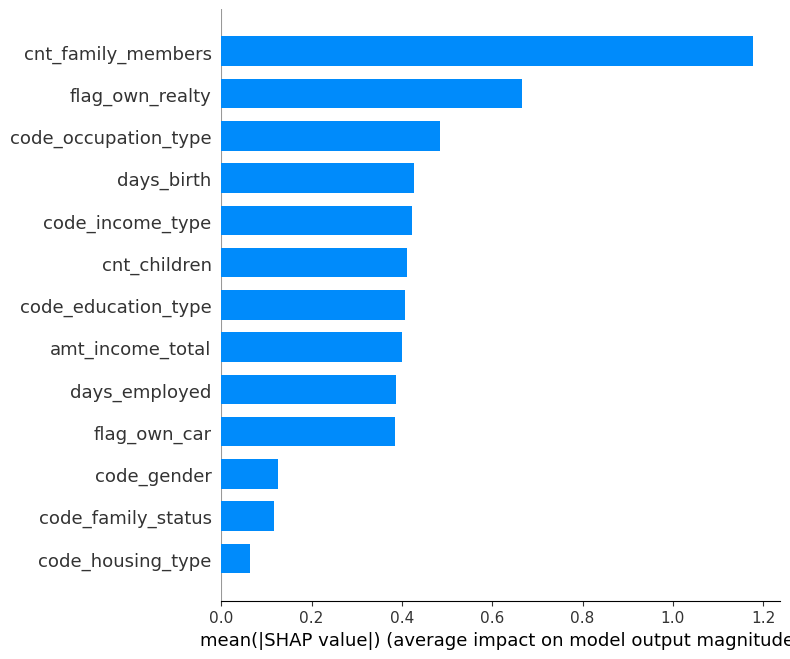

In [43]:
X_sample = X_train.sample(n=1000, random_state=42)

explainer = shap.Explainer(model)
shap_values = explainer(X_sample)


shap.summary_plot(shap_values, X_sample)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [22]:
print(X_test.iloc[0])
X_test

code_gender                  0.000000
flag_own_car                 0.000000
flag_own_realty              0.000000
cnt_children                 1.000000
amt_income_total        270000.000000
code_income_type             2.000000
code_education_type          1.000000
code_family_status           2.000000
code_housing_type            1.000000
days_birth              -10925.000000
days_employed            -2481.000000
code_occupation_type         1.000000
cnt_fam_members              2.511996
Name: 31542, dtype: float64


,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,code_income_type,code_education_type,code_family_status,code_housing_type,days_birth,days_employed,code_occupation_type,cnt_fam_members
31542,0,0,0,1,270000.0,2,1,2,1,-10925,-2481,1,2.511996
25501,0,0,1,0,135000.0,2,1,3,2,-10660,-1935,3,1.000000
1536,0,0,1,2,126000.0,4,1,1,1,-12428,-4900,6,4.000000
13373,0,0,0,0,180000.0,4,2,4,1,-19629,-1897,3,1.000000
19409,1,1,0,0,180000.0,4,4,3,5,-11136,-3487,14,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32887,0,0,1,0,270000.0,4,1,3,1,-10390,-796,14,1.000000
41419,1,1,1,0,202500.0,4,1,2,1,-17585,-3017,4,2.000000
22922,1,1,1,1,112500.0,4,4,1,1,-16204,-925,4,3.000000
21167,1,1,1,0,360000.0,4,1,1,1,-18670,-5431,10,2.000000


In [44]:
model.save_model('xgboost_model.json')